<a href="https://colab.research.google.com/github/eunjoo-ny/ML-Code/blob/main/5_Lesson_5_Data_Augmentation%2C_Regularization_%26_ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch
Part 6 of "Deep Learning with Pytorch: Zero to GANs"


In [75]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [76]:
project_name='05b-cifar10-resnet'

In [77]:
from torchvision.datasets.utils import download_url

In [78]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,'.')

Using downloaded and verified file: ./cifar10.tgz


In [79]:
# Extract from archive
with tarfile.open('./cifar10.tgz','r:gz')as tar:
  tar.extractall(path='./data')

In [86]:
    
# Look into the data directory
data_dir= './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['frog', 'automobile', 'airplane', 'cat', 'truck', 'horse', 'dog', 'bird', 'deer', 'ship']


In [87]:
# Extract from archive
with tarfile.open('./cifar10.tgz','r:gz') as tar:
  tar.extractall(path='./data')

In [88]:
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, 
                                       padding=4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace= True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [89]:
# PyTorch datasets

train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds= ImageFolder(data_dir+'/test',valid_tfms)
train_ds,valid_ds

(Dataset ImageFolder
     Number of datapoints: 50000
     Root location: ./data/cifar10/train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ), Dataset ImageFolder
     Number of datapoints: 10000
     Root location: ./data/cifar10/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

In [90]:
batch_size = 400

In [91]:
# PyTorch data loaders
train_dl= DataLoader(train_ds, batch_size, shuffle=True, num_workers=3,pin_memory=True)
valid_dl= DataLoader(valid_ds, batch_size*2, num_workers=3,pin_memory=True)
valid_dl

In [92]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds= torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [93]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images= denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

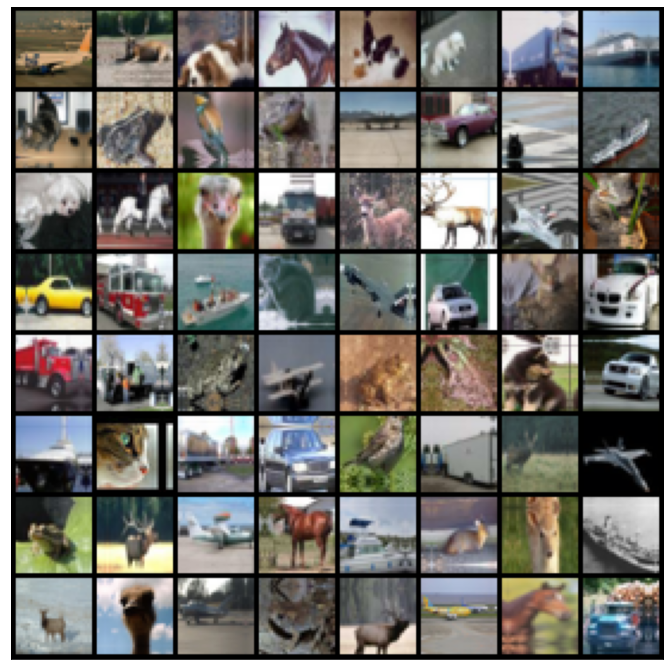

In [94]:
show_batch(train_dl)

In [95]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


In [96]:
def to_device(data, device):
   """Move tensor(s) to chosen device"""
   if isinstance(data, (list,tuple)):
     return [to_device(x,device) for x in data]
   return data.to(device, non_blocking=True)

In [97]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
      self.dl=dl
      self.device= device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [99]:
device = get_default_device()
device

device(type='cuda')

In [101]:
train_dl=DeviceDataLoader(train_dl, device)
valid_dl=DeviceDataLoader(valid_dl, device)
valid_dl,train_dl



(<__main__.DeviceDataLoader at 0x7f50f1d03630>,
 <__main__.DeviceDataLoader at 0x7f50f1d03668>)

In [149]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3,stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out)+x

In [256]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet, images, labels
torch.cuda.empty_cache()


torch.Size([400, 3, 32, 32])


In [257]:
#I can't the difference between my file and the original file-->correct
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels= batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss


  

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc':acc}

   
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs= [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_acc.item()}    

    

   

    
    def epoch_end(self, epoch, result):
        print("Epoch[{}], last_lr:{:.5f}, train_loss: {:.4f}, val_loss:{:.4f},val_acc:{:.4f}".format(
            epoch,result['lrs'][-1],result['train_loss'], result['val_loss'],result['val_acc']))
    
    

In [258]:
#correct
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64,128, pool=True)
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

        self.conv3 =conv_block(128,256,pool=True)
        self.conv4 =conv_block(256,512,pool=True)
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)+out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)+out
        out = self.classifier(out)
        return out

In [259]:
model = to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [269]:
#Mine
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  
    torch.cuda.empty_cache()
    history =[]

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))
    

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs =[]
        for batch in train_loader:
            loss =model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
               nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss']= torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history



In [270]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.9034615159034729, 'val_loss': 0.2901517152786255}]

In [271]:
epochs= 8
max_lr = 0.01
grad_clip=0.1
weight_decay = 1e-4
opt_func=torch.optim.Adam

In [272]:
%%time
history +=fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                        grad_clip=grad_clip,
                        weight_decay=weight_decay,
                        opt_func=opt_func)

Epoch[0], last_lr:0.00393, train_loss: 0.3147, val_loss:0.7694,val_acc:0.7743
Epoch[1], last_lr:0.00935, train_loss: 0.5687, val_loss:0.8124,val_acc:0.7269
Epoch[2], last_lr:0.00972, train_loss: 0.5597, val_loss:0.5799,val_acc:0.8060
Epoch[3], last_lr:0.00812, train_loss: 0.5021, val_loss:0.6810,val_acc:0.7752
Epoch[4], last_lr:0.00556, train_loss: 0.4277, val_loss:0.4380,val_acc:0.8515
Epoch[5], last_lr:0.00283, train_loss: 0.3441, val_loss:0.3966,val_acc:0.8680
Epoch[6], last_lr:0.00077, train_loss: 0.2457, val_loss:0.2730,val_acc:0.9112
Epoch[7], last_lr:0.00000, train_loss: 0.1770, val_loss:0.2523,val_acc:0.9190
CPU times: user 43.2 s, sys: 22.6 s, total: 1min 5s
Wall time: 4min 17s


In [228]:
train_time ='4:24'

In [274]:
def plot_accuracies(history):
    accuracies = [x['val_acc']for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. NO. of epochs');

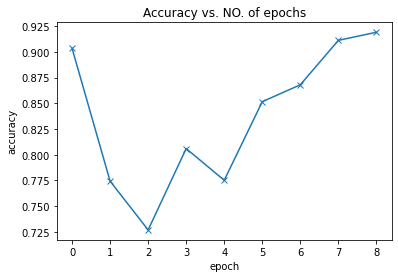

In [275]:
plot_accuracies(history)

In [278]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs.No.of epochs')

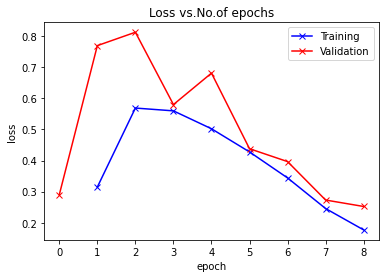

In [279]:
plot_losses(history)

In [284]:
def plot_lrs(history):
    lrs= np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning rate vs Batch no.');

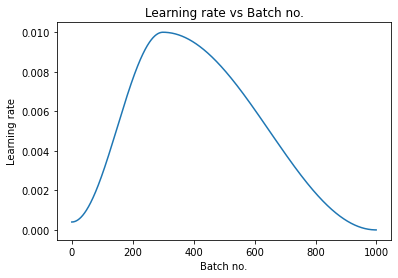

In [285]:
plot_lrs(history)

Testing with individual images


In [286]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _, preds= torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Label: airplane ,Predicted: airplane


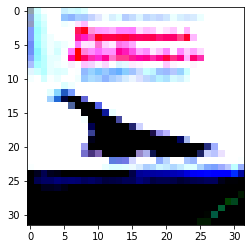

In [287]:
img, label= valid_ds[0]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label],',Predicted:',predict_image(img,model))

Label: automobile ,Predicted: automobile


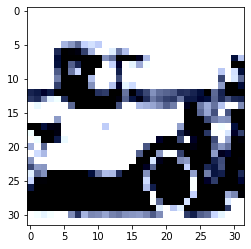

In [288]:
img, label= valid_ds[1002]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label],',Predicted:',predict_image(img,model))

Label: airplane ,Predicted: airplane


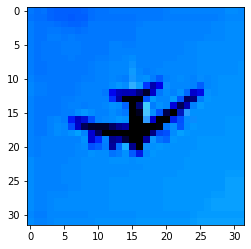

In [289]:
img, label= valid_ds[322]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label],',Predicted:',predict_image(img,model))

Label: frog ,Predicted: frog


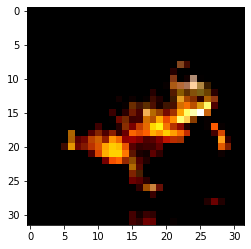

In [290]:
img, label= valid_ds[6153]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label],',Predicted:',predict_image(img,model))

Label: airplane ,Predicted: airplane


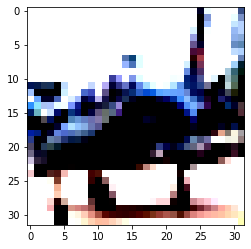

In [291]:
img, label= valid_ds[621]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label],',Predicted:',predict_image(img,model))

In [292]:
torch.save(model.state_dict(),'cifar10-resnet9.pth')

In [293]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 4.0MB/s 


In [294]:
import jovian

In [295]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9',
                       epochs=epochs,
                       lr=max_lr,
                       scheduler ='one-cycle',
                       weight_decay=weight_decay,
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [297]:
jovian.log_metrics(val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [298]:
jovian.commit(project='05b-cifar10-resnet', envrionment=None, ouputs=['cifar10-resnet9.pth'])

[jovian] Detected Colab notebook...


[jovian] Error: Colab File Id is not provided. Make sure to execute the cell where the Id is set.
